# Exercise 6: Supervised learning for 2D Ising model
Before working on this notebook, generate 2D Ising data at several temperatures and save it to file. You should have written a 2D Ising simulation by now, reuse that code. Else, you may adapt one of the solutions to carry out this task.

One possibility is to stringify a configuration by concatenating the rows, e.g. the configuration
<table>
  <tr>
    <td>1</td>
    <td>-1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>-1</td>
    <td>1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>1</td>
  </tr>
</table> 

could become the string "1 1 1 -1 1 1 1 -1 1". Then store all generated configurations in one file, and the temperatures corresponding to the different lines in a different file.

Generate "training" data from ~20 different temperatures, ~1000 configurations per temperature, and "verification" data from different (and potentially more) temperatures (also roughly 1000 configurations per temperature).

Think about whether it makes a difference how you represent the data (e.g. what if we concatenate the rows in a different order?).

# Imports

In [1]:
from tensorflow.keras.models import Sequential
#TODO: Add further imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense

Init Plugin
Init Graph Optimizer
Init Kernel


# Loading the data

In [101]:
#TODO: Load your configurations for training and verification, as well as the corresponding temperatures here
#For example, you could use np.loadtxt()
df_train = pd.read_csv('training_set.csv')
df_validation = pd.read_csv('validation_set.csv')

training_set = df_train.to_numpy()[:,0:-1]#each row contain a stringified grid for a given temperature
training_temp = df_train.to_numpy()[:,-1]#vector of corresponding temperatures for grid from above
validation_set = df_validation.to_numpy()[:,0:-1]
validation_temp = df_validation.to_numpy()[:,-1]

# Sanity check the data

In [ ]:
def plot_configuration(spins):
    '''
    This is a helper function to plot the configuration of spins given by 'spins'
    
    spins - an np.array of shape (N,N) with values in {-1, 1}
    '''
    N = np.shape(spins)[1]
    fig, ax = plt.subplots()
    #fig.add_axes()
    ax = fig.axes[0]
    for i in range(N):
        ax.plot([i, i], [0,N-1], 'k')
        ax.plot([0,N-1], [i,i], 'k')

    colors = ['b', 'gold'] # note: blue is down, gold is up!
    for i in range(N):
        for j in range(N):
            fig.gca().add_patch(plt.Circle((i,j), radius=0.35, fc=colors[int((spins[i,j]+1)/2.)]))
   
    ax.set_ylim(-1,N+1)
    ax.set_xlim(-1,N+1)
    ax.set_aspect('equal')
    plt.axis('off')
    plt.savefig('ising.png')
    fig.show()

In [ ]:
#TODO: Use the above function (or one you write yourself) to check that the loaded configurations make sense

test_grid = training_set[2001,:]
test_grid = test_grid.reshape((30,30))
print(f"configuration for inverse temperature beta = {training_labels[2001]}")
plot_configuration(test_grid)

# Preprocessing the data
In order for the data to be usable in training, you need to
- Define a label coding. For an output layer with two neurons, you could code "ordered phase" as (1,0) and "disordered phase" as (0,1)
- Generate two arrays x and y, such that x contains all configurations and y the corresponding labels, e.g. from {(1,0), (0,1)}. The result should be that the correct label of the configuration x[i] is y[i].
- You may want to discard configurations close to the critical point (why?)

In [3]:
#function which removes entries from array that are in the range [0.44-ϵ, 0.44+ϵ]
def deletion(temp,grid,epsilon):
    indicies = np.argwhere((temp >= 0.44-epsilon) & (temp <= 0.44+epsilon))
    new_temp = np.delete(temp,indicies,0)
    new_grid = np.delete(grid,indicies,0)
    return new_temp, new_grid

In [106]:
#function that creates labels
#input: array of temperatures
#output: array of same size as temp.-array with 0 if temp<0.44 and 1 if temp>0.44
def labeler(temp_arr):
    N = temp_arr.shape[0]
    labels = np.zeros((N,2))
    bigger_inidicies = np.argwhere(temp_arr > 0.44)
    smaller_indicies = np.argwhere(temp_arr <= 0.44)
    labels[bigger_inidicies,0] = 1
    labels[smaller_indicies,1] = 1
    return labels

In [107]:
#TODO: Preprocess the data
"""so our net should only learn if the grid is ordered or disordered?"""

#exclude all samples that are to close to beta = 0.44 (within epsilon range)
training_temp, training_set = deletion(training_temp,training_set,0.02)
#validation_temp, validation_set = deletion(validation_temp,validation_set,0.02)

#create labels
training_labels = labeler(training_temp)
validation_labels = labeler(validation_temp)

# Construct and compile the network
Here you construct the neural network. Follow the link given on the exercise sheet.

Recommendation:
- One hidden layer with 100 neurons and sigmoid activation, fully connected
- Output layer with 2 neurons and softmax activation, fully connected

Feel free to play around with the network setup!

Finally, compile the network.

In [6]:
#TODO: Construct the model
num_inputs = training_set.shape[1] #number of input nodes

model = Sequential()
model.add(Dense(100, input_dim=num_inputs, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

Metal device set to: Apple M1 Pro


2022-04-12 16:29:26.095802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-12 16:29:26.096045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
#TODO: Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Train the network

In [8]:
#TODO: Train ('fit') the model. Experiment with number of epochs and batch sizes.
model.fit(training_set, training_labels, epochs=150, batch_size=10)

2022-04-12 16:29:36.101639: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-12 16:29:36.103874: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/150


2022-04-12 16:29:36.536406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1800/1800 [==============================] - 10s 4ms/step - loss: 0.0274 - accuracy: 0.9962
Epoch 2/150
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0021 - accuracy: 0.9997
Epoch 3/150
1800/1800 [==============================] - 8s 4ms/step - loss: 3.8618e-04 - accuracy: 1.0000
Epoch 4/150
1800/1800 [==============================] - 8s 4ms/step - loss: 1.0005e-04 - accuracy: 1.0000
Epoch 5/150
1800/1800 [==============================] - 8s 4ms/step - loss: 3.7169e-05 - accuracy: 1.0000
Epoch 6/150
1800/1800 [==============================] - 8s 4ms/step - loss: 1.5455e-05 - accuracy: 1.0000
Epoch 7/150
1800/1800 [==============================] - 8s 4ms/step - loss: 6.2949e-06 - accuracy: 1.0000
Epoch 8/150
1800/1800 [==============================] - 8s 4ms/step - loss: 2.5527e-06 - accuracy: 1.0000
Epoch 9/150
1800/1800 [==============================] - 8s 4ms/step - loss: 1.0300e-06 - accuracy: 1.0000
Epoch 10/150
1800/1800 [==============================] 

1800/1800 [==============================] - 8s 4ms/step - loss: 6.1972e-11 - accuracy: 1.0000
Epoch 78/150
1800/1800 [==============================] - 8s 4ms/step - loss: 5.7382e-11 - accuracy: 1.0000
Epoch 79/150
1800/1800 [==============================] - 8s 4ms/step - loss: 5.7382e-11 - accuracy: 1.0000
Epoch 80/150
1800/1800 [==============================] - 8s 4ms/step - loss: 5.7382e-11 - accuracy: 1.0000
Epoch 81/150
1800/1800 [==============================] - 8s 4ms/step - loss: 5.7382e-11 - accuracy: 1.0000
Epoch 82/150
1800/1800 [==============================] - 8s 4ms/step - loss: 5.7382e-11 - accuracy: 1.0000
Epoch 83/150
1800/1800 [==============================] - 8s 4ms/step - loss: 5.7382e-11 - accuracy: 1.0000
Epoch 84/150
1800/1800 [==============================] - 8s 4ms/step - loss: 5.7382e-11 - accuracy: 1.0000
Epoch 85/150
1800/1800 [==============================] - 8s 4ms/step - loss: 5.2791e-11 - accuracy: 1.0000
Epoch 86/150
1800/1800 [=================

In [10]:
#evaluating the model on the validation set
_, accuracy = model.evaluate(validation_set, validation_labels)
print('Accuracy: %.2f' % (accuracy*100))

719/719 [==============================] - 2s 3ms/step - loss: 0.0087 - accuracy: 0.9984
Accuracy: 99.84


# Predictions
Use your trained model to predict the phases of your "validation" configurations. Visualize the results.

For example, you could predict the phase of all configurations at a certain temperature T, then count how many are classified as "disordered" and how many as "ordered". Then plot this as a function of T.

In [108]:
#TODO: Perform predictions, visualize the results and interpret.
predictions = (model.predict(validation_set) > 0.5).astype(int)

In [116]:
num_temp = int(validation_temp.shape[0]/1000) #number of different temperatures in the validation_temp
counter = []
temperatures = []

#for each temp in validation_temp count how many configurations are in the ordered state and store in counter
for i in range(num_temp):
    temp = validation_temp[i*1000]
    indicies = np.argwhere(validation_temp == temp)
    predic = predictions[indicies,:]
    #number of ordered states:
    ordered_states = np.argwhere(predic == [[1,0]]).shape[0]
    counter = np.append(counter,ordered_states)
    temperatures = np.append(temperatures, temp)

counter /= 2000 #normalize the counter

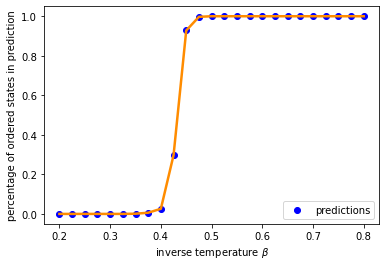

In [117]:

#plot the number of ordered states over the temperature
plt.scatter(temperatures, counter, color='blue', linewidth=1, label='predictions')
plt.plot(temperatures, counter, color='darkorange', linewidth=2.5)
plt.xlabel(r"inverse temperature $\beta$")
plt.ylabel("percentage of ordered states in prediction")
plt.legend(loc="lower right")
#plt.savefig('Ordered_states.svg', format = 'svg', dpi=300)
plt.show()